In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_squared_error, recall_score, precision_score, f1_score
import seaborn as sns
import torch
from kan import KAN
import matplotlib.pyplot as plt

In [9]:
validation_df = pd.read_csv('dataset_tratado/validation_df.csv')
train_df = pd.read_csv('dataset_tratado/train_df.csv')

In [10]:
train_df.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus,satisfaction
0,-0.277804,-0.089306,-1.446976,-0.754370,-0.451942,-0.812200,0.026713,-0.568924,-0.797232,-1.436397,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0
1,-0.216967,-1.004828,-1.446976,-2.083373,-1.279667,-0.812200,-1.460984,-1.438593,-1.564104,-1.436397,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
2,1.668967,-0.408911,1.656614,-0.754370,1.203508,0.852722,0.770562,1.170413,0.736513,0.832220,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
3,0.999764,1.976030,0.622084,1.239135,0.375783,0.020261,0.026713,0.300744,1.503385,0.832220,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
4,1.486457,-0.307045,-0.412446,-0.754370,-0.451942,0.852722,0.770562,-0.568924,0.736513,0.832220,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0


In [14]:
X_train = train_df.drop(columns=['satisfaction']).values
y_train = train_df['satisfaction'].values

In [15]:
X_validation = validation_df.drop(columns=['satisfaction']).values
y_validation = validation_df['satisfaction'].values

## Transformando os dataframes en tensores

In [16]:
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.long)

In [17]:
test_input = torch.tensor(X_validation, dtype=torch.float32)
test_label = torch.tensor(y_validation, dtype=torch.long)

In [18]:
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

## Inicializando e treinando a rede KAN

In [19]:
model = KAN(width=[X_train.shape[1], 2], grid=3, k=3)

In [20]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

In [21]:
results = model.train(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

train loss: 3.65e-01 | test loss: 3.84e-01 | reg: 7.24e+01 : 100%|██| 20/20 [06:24<00:00, 19.20s/it]


Visualizando o modelo

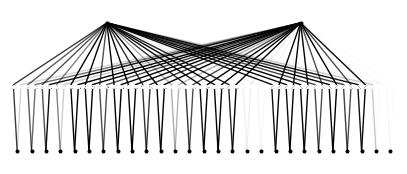

In [22]:
model.plot()

Resultados

In [23]:
# Obter a acurácia final
final_train_acc = results['train_acc'][-1]
final_test_acc = results['test_acc'][-1]

print(f"Acurácia final no conjunto de treino: {final_train_acc:.4f}")
print(f"Acurácia final no conjunto de teste: {final_test_acc:.4f}")

Acurácia final no conjunto de treino: 0.9519
Acurácia final no conjunto de teste: 0.9462


In [37]:
# Calcular o MSE

test_outputs = model(dataset['test_input'])
test_predictions = torch.argmax(test_outputs, dim=1).numpy()

mse = mean_squared_error(y_validation, test_predictions)
print(f"MSE: {mse}")

MSE: 0.05378540305010893


In [41]:
# Calcular o Recall para o conjunto de teste
test_recall = recall_score(y_validation, test_predictions)
print("Test Recall:", test_recall)

Test Recall: 0.9512527233115469


In [43]:
# Calcular a Precision para o conjunto de teste
test_precision = precision_score(y_validation, test_predictions)
print("Test Precision:", test_precision)

Test Precision: 0.9417632785117283


In [44]:
# Calcular o F1-Score para o conjunto de teste
test_f1 = f1_score(y_validation, test_predictions)
print("Test F1-Score:", test_f1)

Test F1-Score: 0.946484216230863


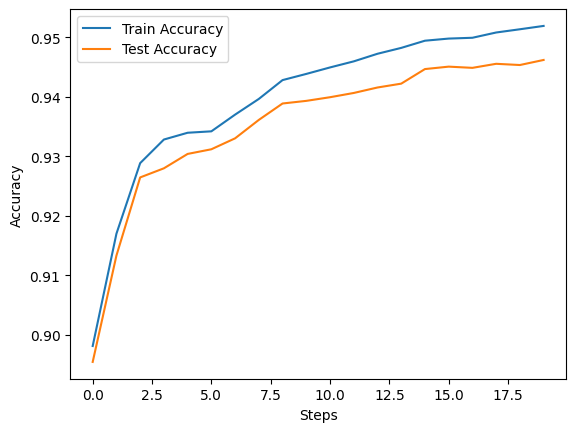

In [24]:
# Plotar os resultados de acurácia (opcional)
plt.plot(results['train_acc'], label='Train Accuracy')
plt.plot(results['test_acc'], label='Test Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

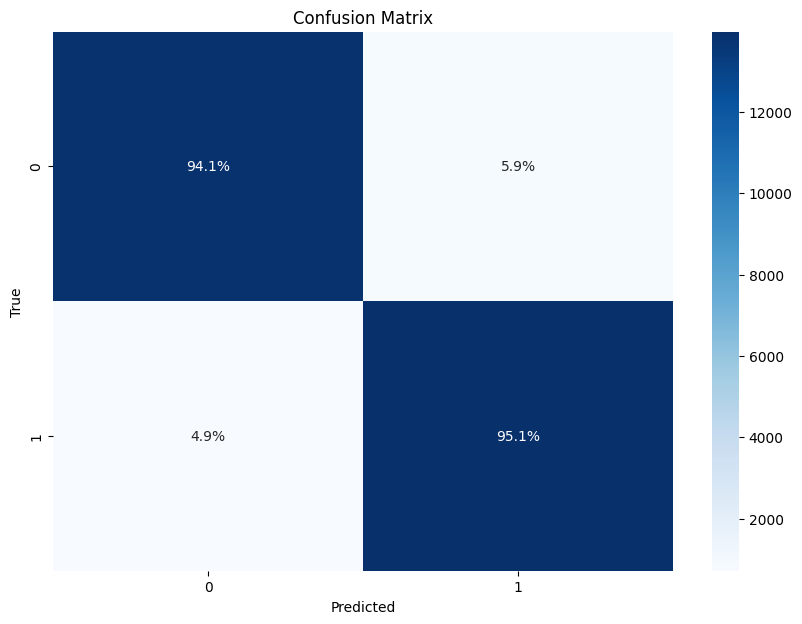

In [27]:
test_outputs = model(dataset['test_input'])
test_predictions = torch.argmax(test_outputs, dim=1).numpy()

conf_matrix = confusion_matrix(y_validation, test_predictions) # trocar por y_test
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

annot_labels = [['{:.1f}%'.format(value) for value in row] for row in conf_matrix_percent]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=annot_labels, fmt='', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

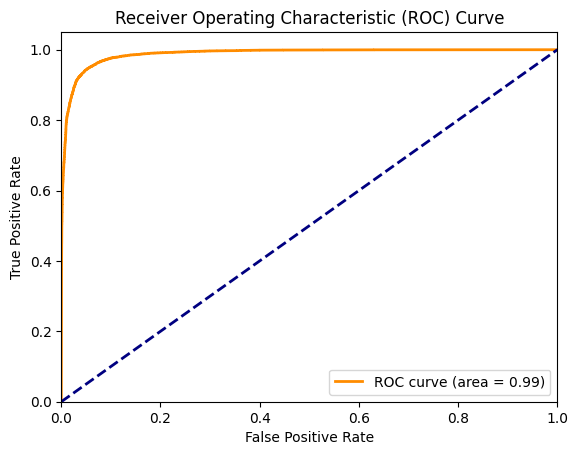

In [28]:
test_probs = torch.softmax(test_outputs, dim=1).detach().numpy()
fpr, tpr, _ = roc_curve(y_validation, test_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

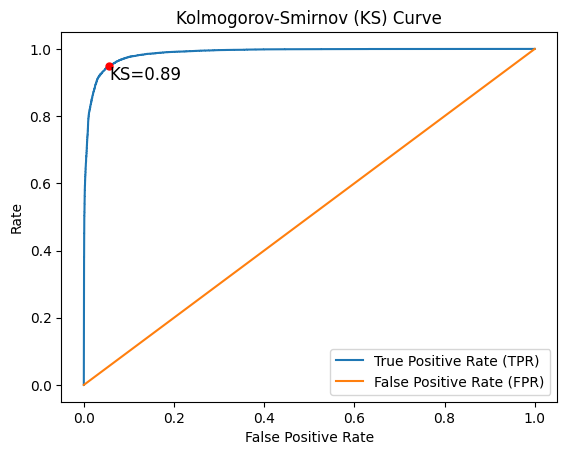

KS Statistic: 0.89


In [29]:
ks_statistic = np.max(tpr - fpr)
ks_idx = np.argmax(tpr - fpr)
plt.figure()
plt.plot(fpr, tpr, label='True Positive Rate (TPR)')
plt.plot(fpr, fpr, label='False Positive Rate (FPR)')
plt.plot([fpr[ks_idx]], [tpr[ks_idx]], marker='o', markersize=5, color="red")
plt.text(fpr[ks_idx], tpr[ks_idx], f'KS={ks_statistic:.2f}', fontsize=12, verticalalignment='top')
plt.xlabel('False Positive Rate')
plt.ylabel('Rate')
plt.title('Kolmogorov-Smirnov (KS) Curve')
plt.legend(loc='best')
plt.show()

print(f"KS Statistic: {ks_statistic:.2f}")

## Grid Search

In [ ]:
def train_and_evaluate_model(width, grid, k, steps, opt):
    model = KAN(width=width, grid=grid, k=k)

    # Funções de avaliação
    def train_acc():
        return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

    def test_acc():
        return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

    results = model.train(dataset, opt=opt, steps=steps, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())
    final_train_acc = results['train_acc'][-1]
    final_test_acc = results['test_acc'][-1]
    return final_train_acc, final_test_acc

Definindo a grade de busca

In [ ]:
param_grid = {
    'width': [[X_train.shape[1], 2]],
    'grid': [2, 3, 4],
    'k': [2, 3, 4],
    'steps': [10, 20, 30, 50, 100],
    'opt' : ['LBFGS', 'Adam']
}

In [ ]:
best_params = None
best_accuracy = 0

# Iterar sobre todas as combinações de hiperparâmetros
for width in param_grid['width']:
    for grid in param_grid['grid']:
        for k in param_grid['k']:
            for opt in param_grid['opt']:
                for steps in param_grid['steps']:
                    train_acc, test_acc = train_and_evaluate_model(width, grid, k, steps, opt)
                    print(f"Width: {width}, Grid: {grid}, K: {k}, Steps: {steps}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
                    
                    if test_acc > best_accuracy:
                        best_accuracy = test_acc
                        best_params = {'width': width, 'grid': grid, 'k': k, 'steps': steps}

Analise da combinação de parâmetros escolhida

In [ ]:
print(f"Best parameters: {best_params}")
print(f"Best test accuracy: {best_accuracy:.4f}")

Treinamento com os parametros escolhidos no Grid Search

In [ ]:
final_model = KAN(width=best_params['width'], grid=best_params['grid'], k=best_params['k'])
results = final_model.train(dataset, opt="LBFGS", steps=best_params['steps'], metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

Avaliação do modelo treinado

In [ ]:
final_model.plot()

In [ ]:
final_train_acc = results['train_acc'][-1]
final_test_acc = results['test_acc'][-1]

print(f"Acurácia final no conjunto de treino: {final_train_acc:.4f}")
print(f"Acurácia final no conjunto de teste: {final_test_acc:.4f}")

In [ ]:
plt.plot(results['train_acc'], label='Train Accuracy')
plt.plot(results['test_acc'], label='Test Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Calcular o MSE

test_outputs = final_model(dataset['test_input'])
test_predictions = torch.argmax(test_outputs, dim=1).numpy()

mse = mean_squared_error(y_validation, test_predictions)
print(f"MSE: {mse}")

MSE: 0.05378540305010893


In [ ]:
# Calcular o Recall para o conjunto de teste
test_recall = recall_score(y_validation, test_predictions)
print("Test Recall:", test_recall)

Test Recall: 0.9512527233115469


In [ ]:
# Calcular a Precision para o conjunto de teste
test_precision = precision_score(y_validation, test_predictions)
print("Test Precision:", test_precision)

Test Precision: 0.9417632785117283


In [ ]:
# Calcular o F1-Score para o conjunto de teste
test_f1 = f1_score(y_validation, test_predictions)
print("Test F1-Score:", test_f1)

Test F1-Score: 0.946484216230863


In [ ]:
test_outputs = final_model(dataset['test_input'])
test_predictions = torch.argmax(test_outputs, dim=1).numpy()

conf_matrix = confusion_matrix(y_validation, test_predictions)
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

annot_labels = [['{:.1f}%'.format(value) for value in row] for row in conf_matrix_percent]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=annot_labels, fmt='', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

In [ ]:
test_probs = torch.softmax(test_outputs, dim=1).detach().numpy()
fpr, tpr, _ = roc_curve(y_validation, test_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
ks_statistic = np.max(tpr - fpr)
ks_idx = np.argmax(tpr - fpr)
plt.figure()
plt.plot(fpr, tpr, label='True Positive Rate (TPR)')
plt.plot(fpr, fpr, label='False Positive Rate (FPR)')
plt.plot([fpr[ks_idx]], [tpr[ks_idx]], marker='o', markersize=5, color="red")
plt.text(fpr[ks_idx], tpr[ks_idx], f'KS={ks_statistic:.2f}', fontsize=12, verticalalignment='top')
plt.xlabel('False Positive Rate')
plt.ylabel('Rate')
plt.title('Kolmogorov-Smirnov (KS) Curve')
plt.legend(loc='best')
plt.show()

print(f"KS Statistic: {ks_statistic:.2f}")